# Alignements of images of M13 

This Notebook illustrates how to derive the offsets between 5 images of M13 using a naive estimates of the shift between the images calculating the center of mass of M13. As shown in Sect. 3 of the Nb [02_Photometry.ipynb](02_Photometry.ipynb) the use of the cross correlation between pairs of images (implemented in `skimage.registration`) is often simpler and more efficient. The method outlined in this exercise may however work more generically. 

In [19]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.io import fits 
import astropy.units as u
from astropy.wcs import WCS
import numpy as np 
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Supplementa Exercise 3.1:** Calculate the center of mass (COM) of M13 on each of the 5 images and use it to align the images 

Load all 5 images of M13 (`'data/M13_blue_000n.fits'`), then:

1. Estimate and subtract the background based on the method you deem the most fitting.
2. Align the images based on the location of their center of mass (align e.g. with respect to first one).
3. Stack them and write a new FITS file, including a modified header.

Tip: use the `shift` function from `scipy.ndimage` for subpixel shifts. Basic usage: `shifted_image = shift(image, (shift_y, shift_x))`. As usual more info in dosctrings.

</div>

**1. Background subtraction**

In [3]:
# load images
nim = 5
cube_M13 = []
for i in range(nim):
    img_M13 = fits.getdata('data/M13_blue_{:04d}.fits'.format(i+1))
    cube_M13.append(img_M13)
cube_M13 = np.array(cube_M13) # convert into a numpy array

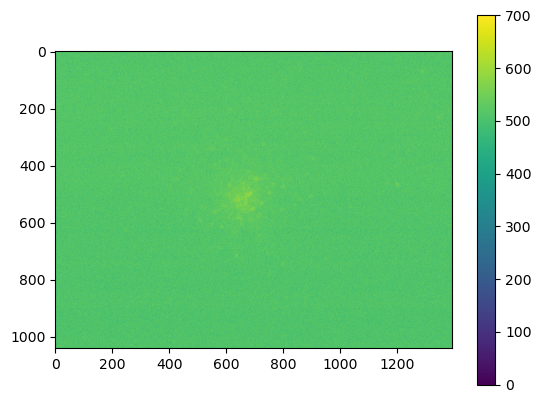

In [4]:
# inspect to better assess the best method for background subtraction
plt.imshow(cube_M13[0])
plt.colorbar()

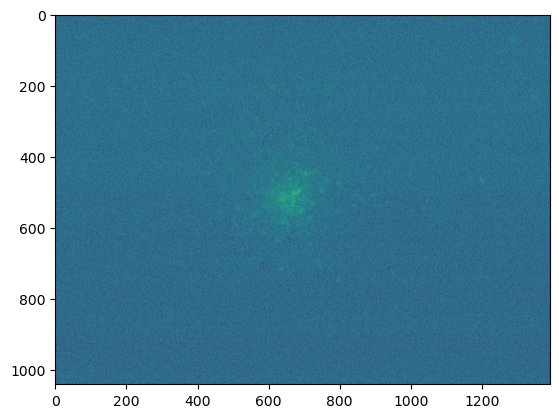

In [5]:
# plot again with a minimum cut set to the first percentile of pixel intensities in the image
plt.imshow(cube_M13[0], vmin=np.percentile(cube_M13[0], 1))

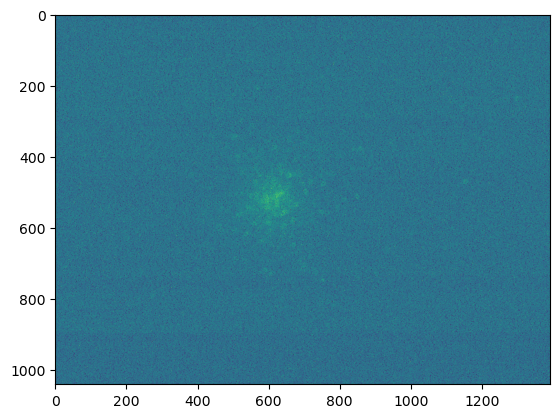

In [6]:
# check the last image too
plt.imshow(cube_M13[-1], vmin=np.percentile(cube_M13[-1], 1))

Let's attempt to subtract a 2D background image estimated through a median filter, after sigma clipping the brightest sources:

In [7]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

bkgs = np.zeros_like(cube_M13)
for i in range(nim):
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg_tmp = Background2D(cube_M13[i], (100, 100), filter_size=(3, 3),
                           sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    bkgs[i] = bkg_tmp.background

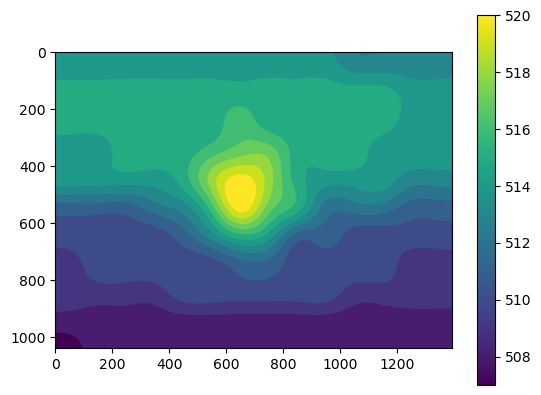

In [8]:
#Let's check:
plt.imshow(bkgs[0])
plt.colorbar()

There is too much flux from stars in the cluster captured in the background. Let's try to adapt the parameters: 

In [9]:
bkgs = np.zeros_like(cube_M13)
for i in range(nim):
    sigma_clip = SigmaClip(sigma=2.5)
    bkg_estimator = MedianBackground()
    bkg_tmp = Background2D(cube_M13[i], (100, 100), filter_size=(3,3),
                           sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    bkgs[i] = bkg_tmp.background

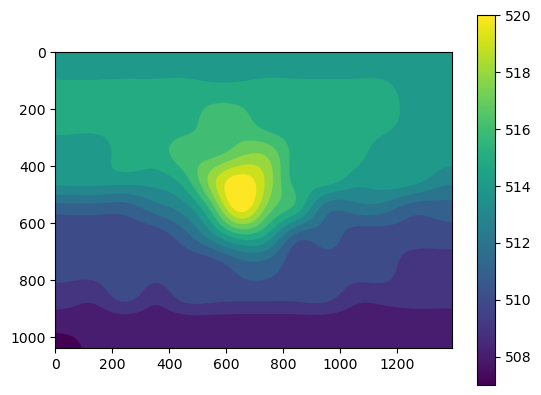

In [10]:
#Let's check:
plt.imshow(bkgs[0])
plt.colorbar()

Although the maximum background value is a bit lower now, the background estimate is still affected by the high density of stars at the center of the cluster. Let's take another approach leveraging the misalignment between the 5 images, and assume the background stays roughly the same. 

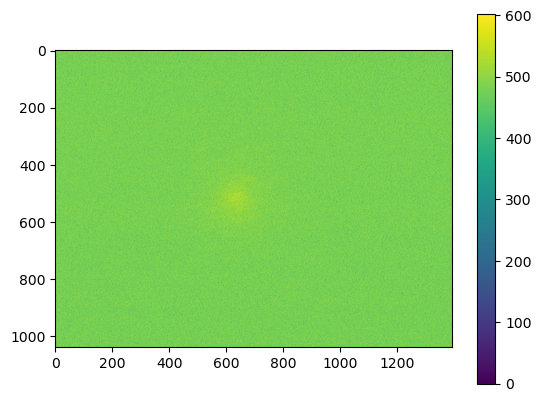

In [11]:
min_of_5imgs = np.amin(cube_M13, axis=0)
plt.imshow(min_of_5imgs)
plt.colorbar()

In [12]:
sigma_clip = SigmaClip(sigma=3)
bkg_estimator = MedianBackground()
single_bkg = Background2D(min_of_5imgs.astype('uint16'), (100, 100), filter_size=(9, 9),
                          sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkg_image = single_bkg.background

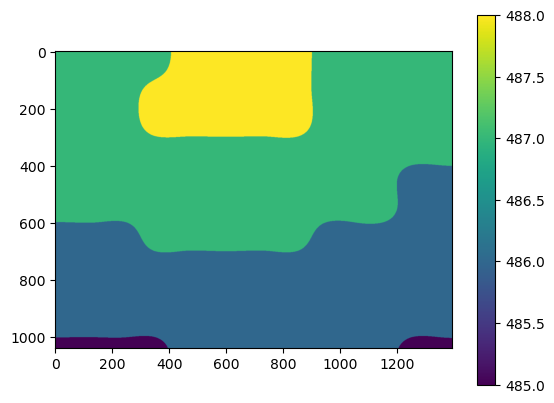

In [13]:
plt.imshow(bkg_image)
plt.colorbar()

In [14]:
M13_minus_bkg = []
for i in range(nim):
    M13_minus_bkg.append(cube_M13[i]-bkg_image)
M13_minus_bkg = np.array(M13_minus_bkg)

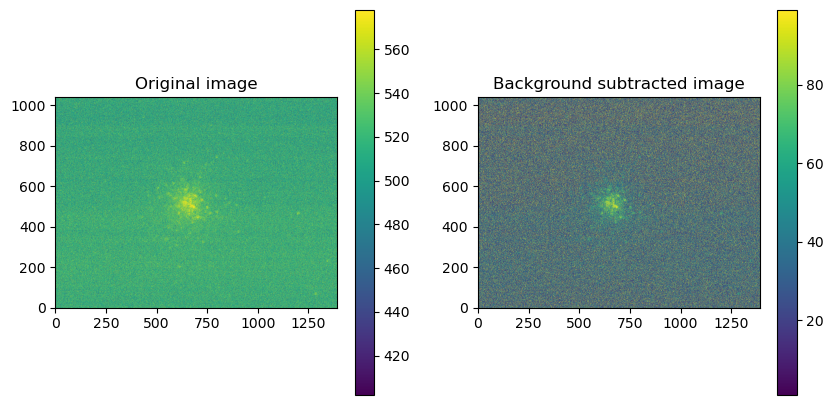

In [15]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
a = ax[0].imshow(cube_M13[0], vmin=np.percentile(cube_M13[0], 1), vmax=np.percentile(cube_M13[0], 99), origin='lower')
ax[0].set_title('Original image')       
plt.colorbar(a)

#b = ax[1].imshow(M13_minus_bkg[0], vmin=0, vmax=100, origin='lower')
b  = ax[1].imshow(M13_minus_bkg[0], vmin=np.percentile(M13_minus_bkg[0], 1), vmax=np.percentile(M13_minus_bkg[0], 85), origin='lower')
ax[1].set_title('Background subtracted image')
plt.colorbar(b)

In [17]:
fits.writeto('outputs/non_aligned_M13.fits', M13_minus_bkg, overwrite=True)

It's not perfect, but it will do the job. In some cases involving crowded fields like this one, the only way to have a better background subtraction is by using dedicated background images, obtained on empty parts of the sky with the same integration time as the science images.

**2. Alignment based on center of mass**

Let's measure the center of mass (effectively a light centroid) in each of the 5 images:

In [20]:
x_com = np.zeros(nim)
y_com = np.zeros(nim)

for i in range(nim):
     x_com[i], y_com[i] = centroid_com(M13_minus_bkg[i])
print(x_com)
print(y_com)

[694.8559479  695.39209514 696.10159148 694.28576343 698.00361709]
[549.63052056 519.99840278 513.62749446 499.50462716 531.68657794]


Let's also try after masking out the edges of the images:

In [21]:
# let non-zero only the central part of the cluster
M13_zer = M13_minus_bkg.copy()
min_thr = 50
max_thr = 250
M13_zer[np.where(M13_minus_bkg<min_thr)] = 0
M13_zer[np.where(M13_minus_bkg>max_thr)] = 0
y_min, y_max = 300, 700
x_min, x_max = 500, 800
M13_zer[:,:y_min] = 0
M13_zer[:,y_max:] = 0
M13_zer[:,:,:x_min] = 0
M13_zer[:,:,x_max:] = 0

for i in range(nim):
     x_com[i], y_com[i] = centroid_com(M13_zer[i])
print(y_com)
print(x_com)

[497.45589063 505.54850522 505.63108436 510.50719899 505.94719979]
[652.43300704 648.02849811 643.02767554 639.18493261 635.88128503]


Let's now try to align the images with respect to the first one:

In [22]:
shifts_y = y_com-y_com[0]
shifts_x = x_com-x_com[0]
print(shifts_y)
print(shifts_x)

[ 0.          8.09261459  8.17519373 13.05130836  8.49130917]
[  0.          -4.40450893  -9.4053315  -13.24807443 -16.551722  ]


In [23]:
from scipy.ndimage import shift

M13_aligned = [M13_minus_bkg[0]]  # keep first image as is 
for i in range(nim-1):
    M13_shift = shift(M13_minus_bkg[i+1], (y_com[0]-y_com[i+1], x_com[0]-x_com[i+1]))   # shift by the difference of COM coordinates
    M13_aligned.append(M13_shift)

M13_aligned = np.array(M13_aligned)

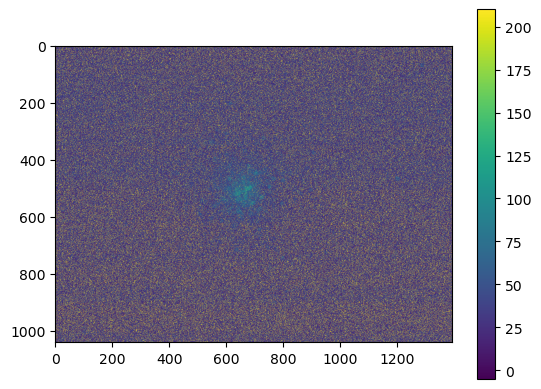

In [24]:
plt.imshow(M13_aligned[0], vmin=-5, vmax=210)
plt.colorbar()

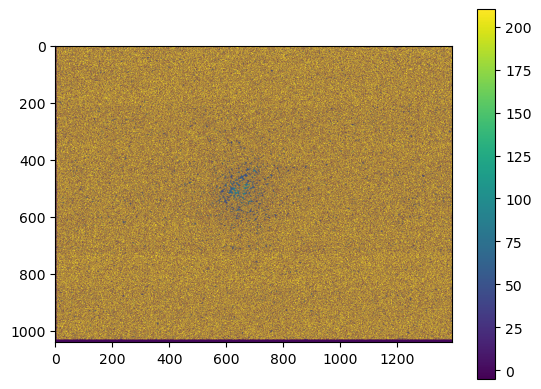

In [25]:
plt.imshow(M13_aligned[1], vmin=-5, vmax=210)
plt.colorbar()

In [26]:
# let's check the alignment by writing a fits file, and opening the fits file
fits.writeto('outputs/aligned_M13.fits', M13_aligned, overwrite=True)

Inspect the results. Why do you think this approach is not doing great?

**3. Stack and write new FITS file**

In [27]:
stacked_image = np.sum(M13_aligned, axis=0)

Let's load the original header for the first file

In [28]:
orihead = fits.getheader('data/M13_blue_0001.fits')

Let's now make a copy and edit the header copy:

In [29]:
from datetime import datetime
now = datetime.now()
new_head = orihead.copy()
new_head['COMMENT'] = 'Combination of 5 images after COM-based alignment'
new_head['HISTORY'] = 'Last edited on '+now.strftime('%Y-%m-%d %H:%M:%S')

In [30]:
new_head

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 1392 /fastest changing axis                           
NAXIS2  =                 1040 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
INSTRUME= 'Orion SSDSI' /       instrument or camera used                       
DATE-OBS= '2013-05-05T04:09:39' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   5.0000000000000000 /Exposure time in seconds                        
EXPOSURE=   5.0000000000000000 /Exposure time in seconds                        
XPIXSZ  =   6.4500000000000002 /Pixel Width in microns (after binning)          
YPIXSZ  =   6.45000000000000

Let's now make save the stacked image with new header:

In [31]:
outfile = 'outputs/M13_blue_stacked.fits'

hdu = fits.PrimaryHDU(stacked_image.astype('uint16'), header=new_head)

### Some unsatisfactory explorations regarding the background subtraction

The cells below illustrate some alternative paths that have been considered to subtract the background for that image but that were not very satisfactory

In [38]:
bkgs = np.zeros_like(cube_M13)
for i in range(nim):
    sigma_clip = SigmaClip(sigma=5.0)
    bkg_estimator = MedianBackground()
    bkg_tmp = Background2D(cube_M13[i], (100, 100), filter_size=(3, 3),
                           sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    bkgs[i] = bkg_tmp.background


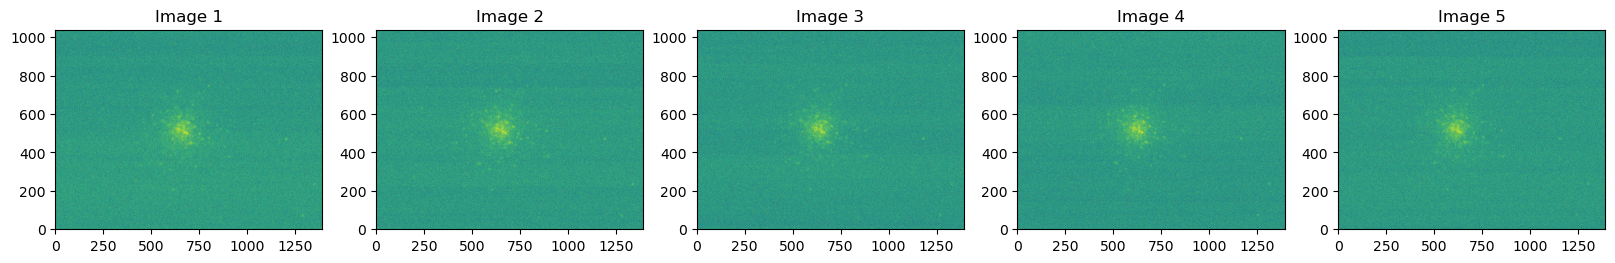

In [39]:
f, ax = plt.subplots(1, 5, figsize=(20, 3))
for i in range(nim):
    ax[i].imshow(cube_M13[i], vmin=400, origin='lower', vmax=600)
    ax[i].set_title('Image {:d}'.format(i+1))

0 507 520
1 509 519
2 507 516
3 507 516
4 506 516


(5, 1040, 1392)

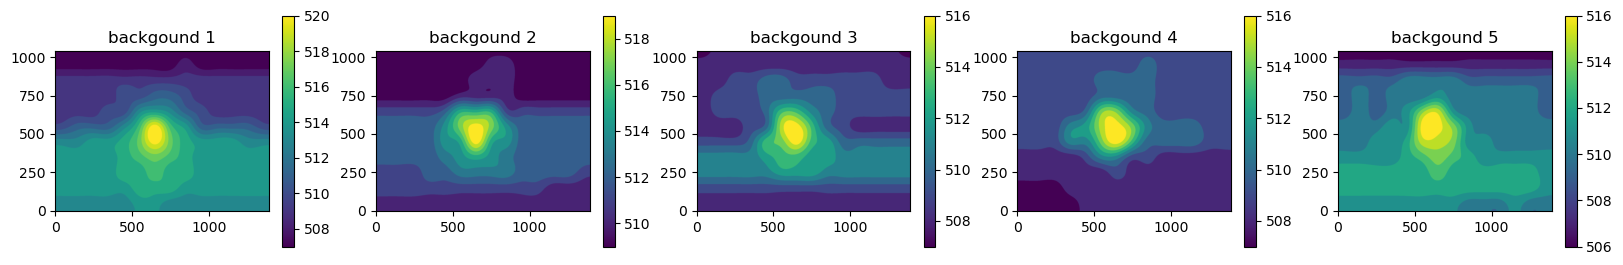

In [40]:
f, ax = plt.subplots(1, 5, figsize=(20, 3))
for i in range(nim):
    a = ax[i].imshow(bkgs[i],  origin='lower')
    ax[i].set_title('backgound {:d}'.format(i+1))
    print(i, bkgs[i].flatten().min(), bkgs[i].flatten().max())
    plt.colorbar(ax=ax[i], mappable=a)
M13_minus_bkg = cube_M13 - np.array(bkgs)
cube_M13.shape

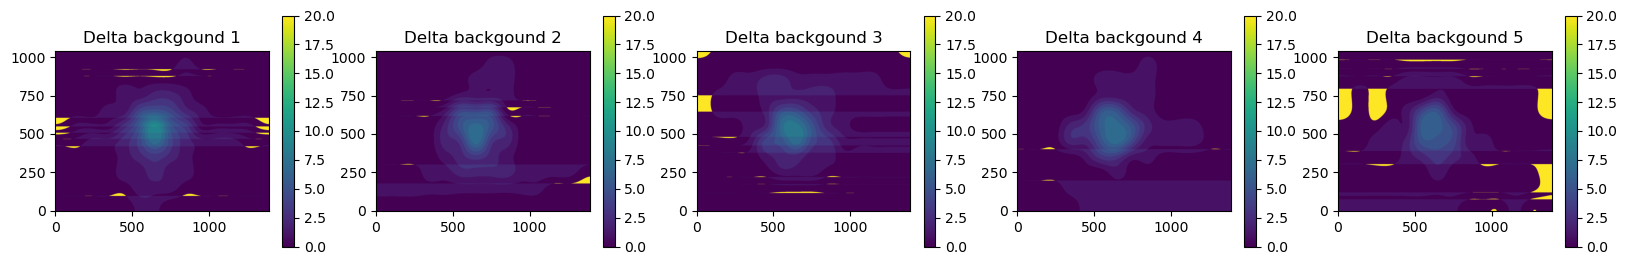

In [41]:
# SInce there is an apparent gradient along the y axis, we can make a background based on the pixels in with x in [0:200] & x in [1000:]
bg_approx = np.zeros_like(cube_M13)
for i in range(nim):
    bg_approx[i, :, :] = ( np.median(bkgs[i][:, :200], axis=1)[:, np.newaxis] + np.median(bkgs[i][:, 1000:], axis=1)[:, np.newaxis] ) / 2. 

f, ax = plt.subplots(1, 5, figsize=(20, 3))
for i in range(nim):
#    a = ax[i].imshow(bg_approx[i, :, :],  origin='lower')
    a = ax[i].imshow(bkgs[i] - bg_approx[i, :, :],  origin='lower', vmin=0, vmax=20 )
    ax[i].set_title('Delta backgound {:d}'.format(i+1))
#    print(i, bg_approx[i].flatten().min(), bg_approx[i].flatten().max())
    plt.colorbar(ax=ax[i], mappable=a)

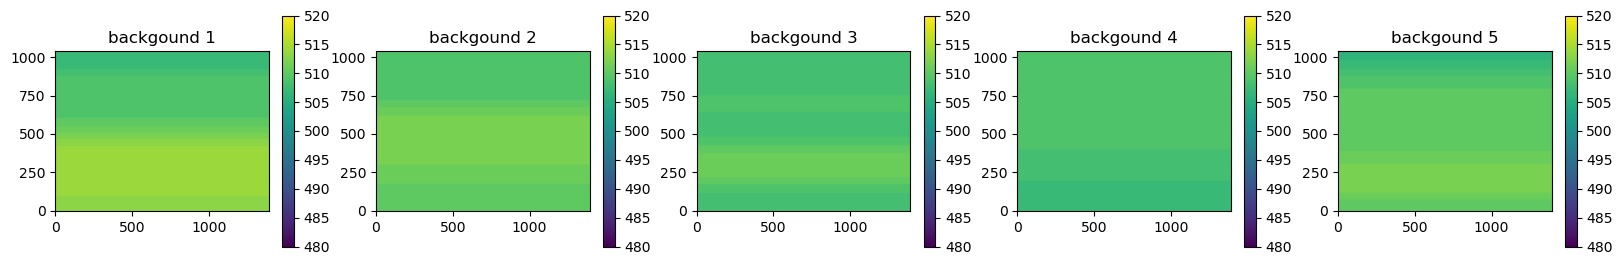

In [44]:
f, ax = plt.subplots(1, 5, figsize=(20, 3))
for i in range(nim):
#    a = ax[i].imshow(bg_approx[i, :, :],  origin='lower')
    a = ax[i].imshow(bg_approx[i, :, :],  origin='lower', vmin=480, vmax=520 )
    ax[i].set_title('backgound {:d}'.format(i+1))
#    print(i, bg_approx[i].flatten().min(), bg_approx[i].flatten().max())
    plt.colorbar(ax=ax[i], mappable=a)

The problem of this background is that it is too large ... as shown above, calculating the background on the minimum of the 5 images yields a background level substantially lower. 